<a href="https://colab.research.google.com/github/matias258/Labo_de_Datos/blob/main/LSMA_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSMA para Bitcoin. (Least Squares Moving Average)

Vamos a hacer LSMA sobre los Low del precio de BTC, desde Enero 2012 hasta hoy.

Entonces, nuestros datos seran de este estilo:
- {$(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)$}

Lo primero que haremos es fijar un **k** (periodo de tiempo).

Notamos como $\hat{y}$ a la estimacion de LSMA para $x_i$, y se calcula de la siguiente manera:
- $\hat{y} = \beta_0 + \beta_1x_i$

Donde $\beta_0$ y $\beta_1$ son los coeficientes de la **Regresion Lineal sobre los anteriores k datos**
- {$(x_{1-k-1}, y_{1-k-1}), (x_{2-k-1}, y_{2-k-1}), ..., (x_{i-1}, y_{i-1})$}

In [47]:
pip install formulaic

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño

from formulaic import Formula
import kagglehub

In [49]:
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/46


In [59]:
import os

files = os.listdir(path)
print("Archivos en el dataset:", files)

Archivos en el dataset: ['btcusd_1-min_data.csv']


In [60]:
import pandas as pd

# Define la ruta completa al archivo CSV
csv_path = os.path.join(path, 'btcusd_1-min_data.csv')

# Cargar los datos en un DataFrame
df = pd.read_csv(csv_path)

df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

# Limpiar los NaN de Low y Timestamp
df = df.dropna(subset=['Low', 'Timestamp'])

# Agrupar por día y tomar el mínimo precio de cada día (Low)
df_daily = df.resample('D', on='Date').agg({'Low': 'min'}).reset_index()


In [89]:
# Calcular el promedio móvil simple con ventana de 7 días
df_daily['LSMA_7'] = df_daily['Low'].rolling(window=7).mean()
df_daily['LSMA_1_MONTH'] = df_daily['Low'].rolling(window=31).mean()
df_daily['LSMA_6_MONTHS'] = df_daily['Low'].rolling(window=183).mean()
df_daily['LSMA_1_YEAR'] = df_daily['Low'].rolling(window=365).mean()

print(df_daily[['Date', 'Low','LSMA_1_MONTH','LSMA_6_MONTHS','LSMA_1_YEAR']].tail(10))  # Ver las últimas filas

           Date      Low  LSMA_1_MONTH  LSMA_6_MONTHS   LSMA_1_YEAR
4668 2024-10-12  62631.0  61542.000000   61716.103825  54126.443836
4669 2024-10-13  63179.0  61733.903226   61712.693989  54226.279452
4670 2024-10-14  64020.0  61939.709677   61727.513661  54328.252055
4671 2024-10-15  66070.0  62153.645161   61747.896175  54435.260274
4672 2024-10-16  66827.0  62415.548387   61776.163934  54541.413699
4673 2024-10-17  67608.0  62742.000000   61819.530055  54649.501370
4674 2024-10-18  67629.0  63064.645161   61856.874317  54757.695890
4675 2024-10-19  68420.0  63362.419355   61904.912568  54866.805479
4676 2024-10-20  68208.0  63570.774194   61933.333333  54972.901370
4677 2024-10-21  69011.0  63785.548387   61959.109290  55080.663014


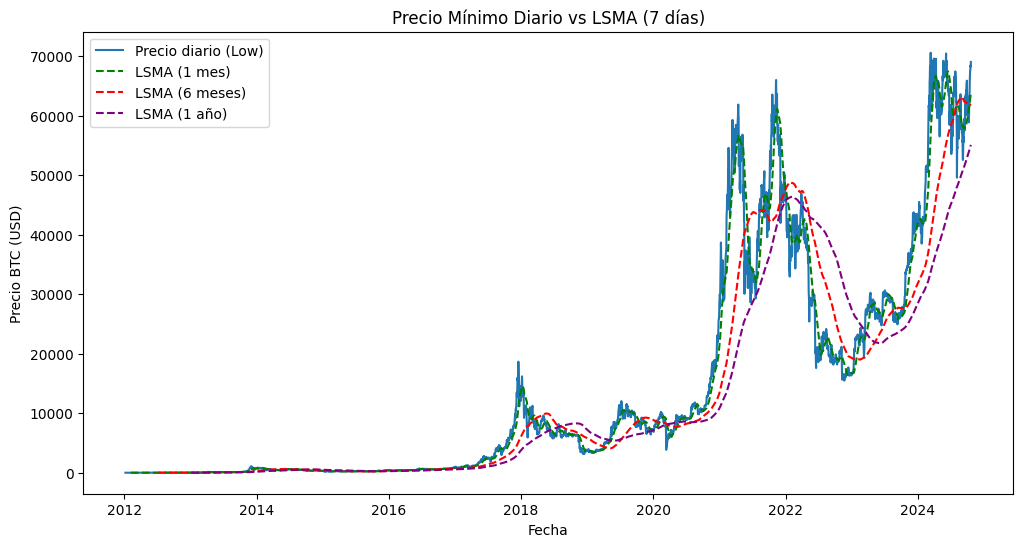

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date'], df_daily['Low'], label='Precio diario (Low)', linestyle = "-")
# plt.plot(df_daily['Date'], df_daily['LSMA_7'], label='LSMA (7 días)', linestyle='--', color='orange')
plt.plot(df_daily['Date'], df_daily['LSMA_1_MONTH'], label='LSMA (1 mes)', linestyle='--', color='green')
plt.plot(df_daily['Date'], df_daily['LSMA_6_MONTHS'], label='LSMA (6 meses)', linestyle='--', color='red')
plt.plot(df_daily['Date'], df_daily['LSMA_1_YEAR'], label='LSMA (1 año)', linestyle='--', color='purple')
plt.xlabel('Fecha')
plt.ylabel('Precio BTC (USD)')
plt.title('Precio Mínimo Diario vs LSMA (7 días)')
plt.legend()
plt.show()


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Usar solo las filas sin NaN en 'LSMA_7'
df_daily = df_daily.dropna(subset=['LSMA_7'])

# Definir X como los índices de tiempo (pueden ser fechas convertidas a ordinal)
X = df_daily['Date'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = df_daily['LSMA_7'].values

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear características polinómicas
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Ajustar un modelo de regresión lineal polinómica
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 8540.977353948934
R²: 0.7815030291668024
